In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import pickle

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = './experiment_set_15_1'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [8]:
def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     cmapss_score))
    return mse, rmse, cmapss_score
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', dropout=0, output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    
    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def save_object(obj, output_file):
    with open(output_file, 'wb') as file:
        pickle.dump(obj, file)
    print("Saved object to file: {}".format(output_file))
    
def load_object(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)
    
def numbers_list_to_string(num_list):
    return " ".join([str(x) for x in num_list])

In [17]:
class MLPConfigParams:
    def __init__(self, layer_sizes=(), activation='tanh', dropout=0.0):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.dropout = dropout


def train_evaluate_mlp(x_train, y_train, x_test, y_test, num_trials, 
                       mlp_config_params, results_path, epochs, batch_size, results_file=None):
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    input_dim = x_train.shape[1]
    
    for trial_num in range(num_trials):
        # Create results path for current split
        results_path_crr_split = os.path.join(results_path, "split_{}".format(trial_num))
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)
        
        
        # Train-validation split
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1, 
                                                                                  random_state=trial_num)
        
        # Standardization
        scaler_file = os.path.join(results_path_crr_split, 'scaler.pkl')
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        save_object(scaler, scaler_file)
        
        weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
        
        # Initialize weights only in first split
        if trial_num == 0:
            model = create_mlp_model(input_dim, 
                                     hidden_layer_sizes=mlp_config_params.layer_sizes, 
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout,
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim, 
                                     hidden_layer_sizes=mlp_config_params.layer_sizes, 
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout)
        model.summary()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=2, 
                             save_best_only=True)
        
        # Train model
        history = train_model_existing_weights(model, weights_file, 
                                               x_train_scaled, y_train_split, 
                                               x_val_scaled, y_val_split, 
                                               batch_size=batch_size, 
                                               epochs=epochs,
                                               callbacks=[es, mc])

        history_file = os.path.join(results_path_crr_split, f"history_{trial_num}.pkl")
        plot_loss_curves(history.history)
        save_history(history, history_file)
        
        # Performance evaluation
        x_test_scaled = scaler.transform(x_test)
        loaded_model = load_model(model_path)
        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
        
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
        
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    if results_file is not None:
        with open(results_file, "a") as file:
            line_to_write = f"{numbers_list_to_string(mse_vals)}, {numbers_list_to_string(rmse_vals)},"
            line_to_write += f"{numbers_list_to_string(cmapss_vals)}, {mse_mean}, {mse_std}, {rmse_mean},"
            line_to_write += f"{rmse_std}, {cmapss_mean}, {cmapss_std}\n"
            file.write(line_to_write)

    return mse_vals, rmse_vals, cmapss_vals

def train_evaluate_mlp_entire_dataset(x_train, y_train, x_test, y_test, validation_set_size,
                                      mlp_config_params, results_path, epochs, batch_size):
    # Train-validation split for early stopping
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, 
                                                                              y_train, 
                                                                              test_size=validation_set_size, 
                                                                              random_state=seed)


    # Standardization
    scaler_file = os.path.join(results_path, 'scaler.pkl')
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_split)
    x_val_scaled = scaler.transform(x_val_split)
    input_dim = x_train_scaled.shape[1]
    save_object(scaler, scaler_file)

    # Create model
    weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
    model_path = os.path.join(results_path, 'mlp_model_trained.h5')

    model = create_mlp_model(input_dim, 
                             hidden_layer_sizes=mlp_config_params.layer_sizes, 
                             activation=mlp_config_params.activation,
                             dropout=mlp_config_params.dropout,
                             output_weights_file=weights_file)


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, 
                         save_best_only=True)

    # Train model
    history = train_model_existing_weights(model, weights_file, 
                                           x_train_scaled, y_train_split, 
                                           x_val_scaled, y_val_split, 
                                           batch_size=batch_size, 
                                           epochs=epochs, 
                                           callbacks=[es, mc])

    history_file = os.path.join(results_path, "history.pkl")
    plot_loss_curves(history.history)
    save_history(history, history_file)

    # Performance evaluation
    x_test_scaled = scaler.transform(x_test)

    loaded_model = load_model(model_path)
    predictions_test = loaded_model.predict(x_test_scaled).flatten()
    mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
    return mse, rmse, cmapss_score

In [10]:
def exponential_smoothing(df, columns, alpha):
    df = df.copy()
    df[columns] = df.groupby('unit')[columns].apply(
        lambda x: x.ewm(alpha=alpha, adjust=False).mean())
    return df

def moving_average(df, columns, window):
    df = df.copy()
    df[columns] = df.groupby('unit')[columns].apply(
        lambda x: x.rolling(window, min_periods=1).mean())
    return df

def signal_smoothing(df, columns, filter_type, filter_param):
    if filter_type == 'es':
        return exponential_smoothing(df, columns, alpha=filter_param)
    elif filter_type == 'ma':
        return moving_average(df, columns, window=filter_param)
    else:
        raise RuntimeError("Invalid filter type")

In [11]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print("Train set shape: " + str(train_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 
columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

Operation time (sec):  3.859375
Train set shape: (5263447, 47)


In [12]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

In [13]:
selected_columns = columns_operating_conditions + columns_sensor_measurements
selected_columns_with_unit = selected_columns + ['unit']
x_train = x_train[selected_columns_with_unit]
x_test = x_test[selected_columns_with_unit]

In [14]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

Saved object to file: ./experiment_set_15_1\results_None_0\split_0\scaler.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 235,137
Trainable params: 235,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
6465/6477 [================

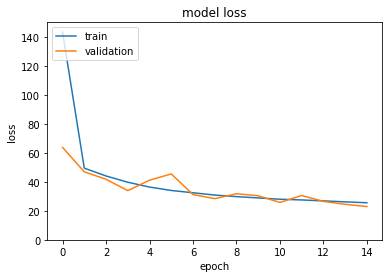

Saved training history to file: ./experiment_set_15_1\results_None_0\split_0\history_0.pkl
Test set:
MSE: 22.85
RMSE: 4.78
CMAPSS score: 1.40

Saved object to file: ./experiment_set_15_1\results_None_0\split_1\scaler.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               4864      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 235,137
Trainable

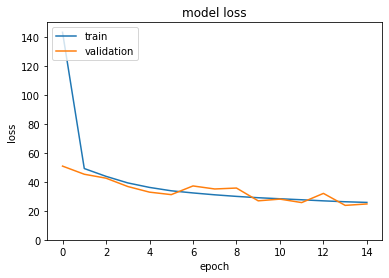

Saved training history to file: ./experiment_set_15_1\results_None_0\split_1\history_1.pkl
Test set:
MSE: 23.68
RMSE: 4.87
CMAPSS score: 1.42

Saved object to file: ./experiment_set_15_1\results_None_0\split_2\scaler.pkl
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable

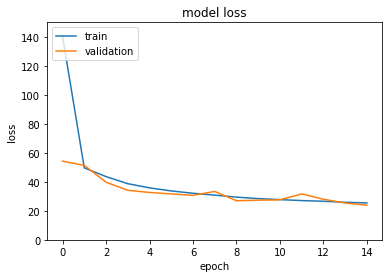

Saved training history to file: ./experiment_set_15_1\results_None_0\split_2\history_2.pkl
Test set:
MSE: 23.75
RMSE: 4.87
CMAPSS score: 1.43

Saved object to file: ./experiment_set_15_1\results_ma_5\split_0\scaler.pkl
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable p

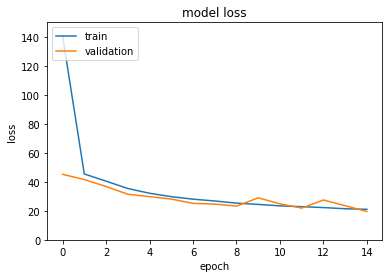

Saved training history to file: ./experiment_set_15_1\results_ma_5\split_0\history_0.pkl
Test set:
MSE: 19.48
RMSE: 4.41
CMAPSS score: 1.36

Saved object to file: ./experiment_set_15_1\results_ma_5\split_1\scaler.pkl
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable par

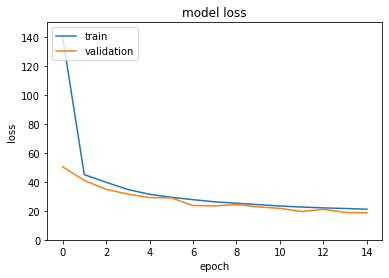

Saved training history to file: ./experiment_set_15_1\results_ma_5\split_1\history_1.pkl
Test set:
MSE: 18.70
RMSE: 4.32
CMAPSS score: 1.34

Saved object to file: ./experiment_set_15_1\results_ma_5\split_2\scaler.pkl
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable par

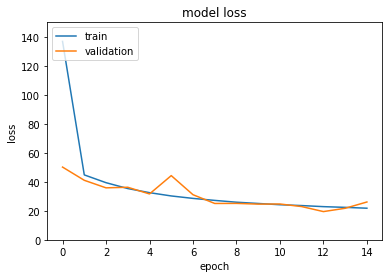

Saved training history to file: ./experiment_set_15_1\results_ma_5\split_2\history_2.pkl
Test set:
MSE: 19.40
RMSE: 4.40
CMAPSS score: 1.35

Saved object to file: ./experiment_set_15_1\results_ma_10\split_0\scaler.pkl
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable pa

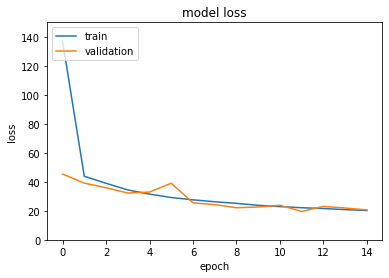

Saved training history to file: ./experiment_set_15_1\results_ma_10\split_0\history_0.pkl
Test set:
MSE: 19.46
RMSE: 4.41
CMAPSS score: 1.36

Saved object to file: ./experiment_set_15_1\results_ma_10\split_1\scaler.pkl
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_38 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable p

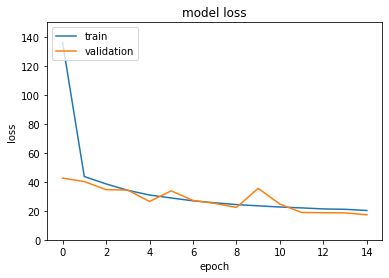

Saved training history to file: ./experiment_set_15_1\results_ma_10\split_1\history_1.pkl
Test set:
MSE: 17.31
RMSE: 4.16
CMAPSS score: 1.33

Saved object to file: ./experiment_set_15_1\results_ma_10\split_2\scaler.pkl
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_42 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_43 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable p

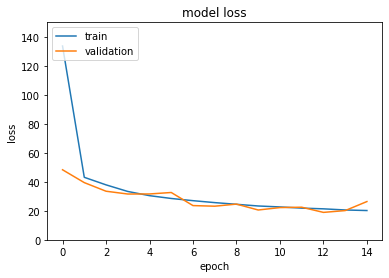

Saved training history to file: ./experiment_set_15_1\results_ma_10\split_2\history_2.pkl
Test set:
MSE: 18.83
RMSE: 4.34
CMAPSS score: 1.35

Saved object to file: ./experiment_set_15_1\results_ma_15\split_0\scaler.pkl
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_46 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_47 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_48 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable p

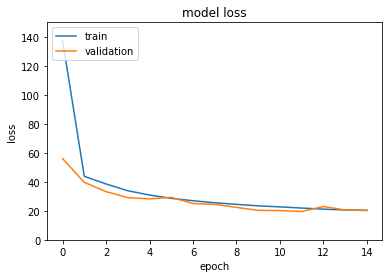

Saved training history to file: ./experiment_set_15_1\results_ma_15\split_0\history_0.pkl
Test set:
MSE: 19.47
RMSE: 4.41
CMAPSS score: 1.36

Saved object to file: ./experiment_set_15_1\results_ma_15\split_1\scaler.pkl
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_51 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_52 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_53 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable 

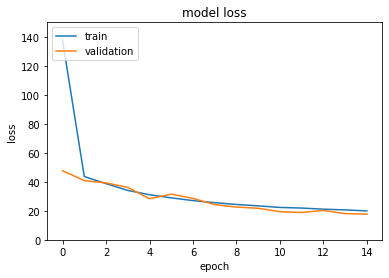

Saved training history to file: ./experiment_set_15_1\results_ma_15\split_1\history_1.pkl
Test set:
MSE: 17.73
RMSE: 4.21
CMAPSS score: 1.34

Saved object to file: ./experiment_set_15_1\results_ma_15\split_2\scaler.pkl
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_57 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_58 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable 

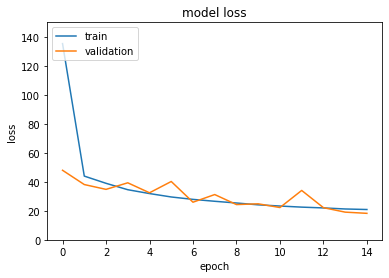

Saved training history to file: ./experiment_set_15_1\results_ma_15\split_2\history_2.pkl
Test set:
MSE: 18.23
RMSE: 4.27
CMAPSS score: 1.34

Saved object to file: ./experiment_set_15_1\results_ma_20\split_0\scaler.pkl
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_61 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_62 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_63 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable 

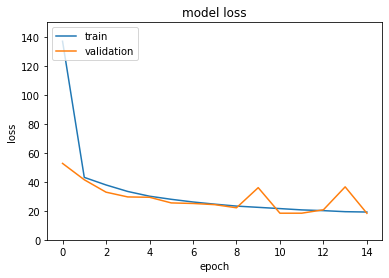

Saved training history to file: ./experiment_set_15_1\results_ma_20\split_0\history_0.pkl
Test set:
MSE: 18.22
RMSE: 4.27
CMAPSS score: 1.33

Saved object to file: ./experiment_set_15_1\results_ma_20\split_1\scaler.pkl
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_66 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_67 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_68 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable 

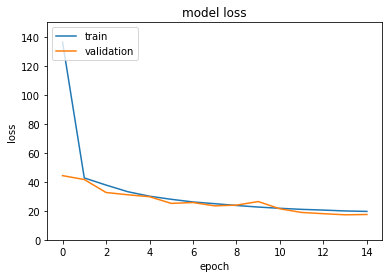

Saved training history to file: ./experiment_set_15_1\results_ma_20\split_1\history_1.pkl
Test set:
MSE: 17.31
RMSE: 4.16
CMAPSS score: 1.32

Saved object to file: ./experiment_set_15_1\results_ma_20\split_2\scaler.pkl
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_71 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_72 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 65        
Total params: 235,137
Trainable 

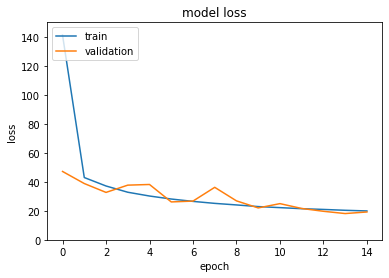

Saved training history to file: ./experiment_set_15_1\results_ma_20\split_2\history_2.pkl
Test set:
MSE: 18.01
RMSE: 4.24
CMAPSS score: 1.34



In [17]:
#########################################
# Effect of smoothing (experiment set 14)
#########################################
NUM_TRIALS = 3
EPOCHS = 15
BATCH_SIZE = 512

mlp_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)
alpha_vals = [0.01, 0.05, 0.1, 0.2, 0.3]
w_vals = [5, 10, 15, 20]

filter_params = [("None", 0)] + [("es", alpha) for alpha in alpha_vals] + [("ma", w) for w in w_vals]

results_file = os.path.join(output_path, "results_filtering.csv")
with open(results_file, "w") as file:
    file.write("filter_type,filter_param,mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")


for params in filter_params:
    filter_type, filter_param = params
    
    results_folder = f"results_{filter_type}_{filter_param}"
    results_path = os.path.join(output_path, results_folder)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    # Filtering
    if filter_type == "None":
        x_train_filtered = x_train[selected_columns].astype(np.float32)
    else:
        x_train_filtered = signal_smoothing(x_train, selected_columns, filter_type, filter_param)
        x_train_filtered = x_train_filtered[selected_columns].astype(np.float32)
    
    # Validation split
    x_train_filtered, x_holdout_filtered, y_train_filtered, y_holdout_filtered = train_test_split(
        x_train_filtered, 
        y_train, 
        test_size=0.3, 
        random_state=seed)
    
    mse_vals, rmse_vals, cmapss_vals = train_evaluate_mlp(
        x_train_filtered, y_train_filtered, 
        x_holdout_filtered, y_holdout_filtered,
        NUM_TRIALS, 
        mlp_params, 
        results_path, 
        EPOCHS, BATCH_SIZE,
        results_file=results_file)

Saved object to file: ./experiment_set_15\result_alpha_0.05_final\scaler.pkl
Epoch 1/60
9247/9253 [============================>.] - ETA: 0s - loss: 106.2508
Epoch 00001: val_loss improved from inf to 40.81924, saving model to ./experiment_set_15\result_alpha_0.05_final\mlp_model_trained.h5
9253/9253 [==============================] - 37s 4ms/step - loss: 106.2139 - val_loss: 40.8192
Epoch 2/60
9239/9253 [============================>.] - ETA: 0s - loss: 37.9071
Epoch 00002: val_loss improved from 40.81924 to 36.21931, saving model to ./experiment_set_15\result_alpha_0.05_final\mlp_model_trained.h5
9253/9253 [==============================] - 37s 4ms/step - loss: 37.9058 - val_loss: 36.2193
Epoch 3/60
9247/9253 [============================>.] - ETA: 0s - loss: 32.9910
Epoch 00003: val_loss improved from 36.21931 to 30.65921, saving model to ./experiment_set_15\result_alpha_0.05_final\mlp_model_trained.h5
9253/9253 [==============================] - 37s 4ms/step - loss: 32.9888 - val_l

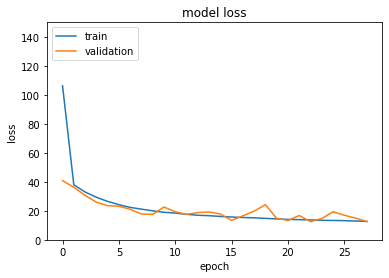

Saved training history to file: ./experiment_set_15\result_alpha_0.05_final\history.pkl
Test set:
MSE: 64.49
RMSE: 8.03
CMAPSS score: 1.80



In [49]:
# Train single MLP
EPOCHS = 60
BATCH_SIZE = 512
mlp_config_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)
alpha = 0.05

results_path = os.path.join(output_path, f"result_alpha_{alpha}_final")
if not os.path.exists(results_path):
    os.makedirs(results_path)
    
x_train_filtered = exponential_smoothing(x_train, selected_columns, alpha=alpha)
x_test_filtered = exponential_smoothing(x_test, selected_columns, alpha=alpha)

x_train_filtered = x_train_filtered[selected_columns].astype(np.float32)
x_test_filtered = x_test_filtered[selected_columns].astype(np.float32)

train_evaluate_mlp_entire_dataset(
        x_train_filtered, y_train, 
        x_test_filtered, y_test,
        0.1,
        mlp_config_params, 
        results_path, 
        EPOCHS, BATCH_SIZE)

In [50]:
def plot_signal_filtering(df, signal_name, alpha=0.05, w=10):
    signal = df[signal_name][:200]
    smooth_signal_es = signal.ewm(alpha=alpha, adjust=False).mean()
    smooth_signal_ma = signal.rolling(w, min_periods=1).mean()
    
    plt.figure()
    plt.title(f"Value of signal {signal_name}")
    plt.xlabel("Time (num observations)")
    plt.ylabel("Value")
    plt.plot(signal, label='Original')
    plt.plot(smooth_signal_es, label='Exponential smoothing')
    plt.plot(smooth_signal_ma, label='Moving average')
    plt.legend()

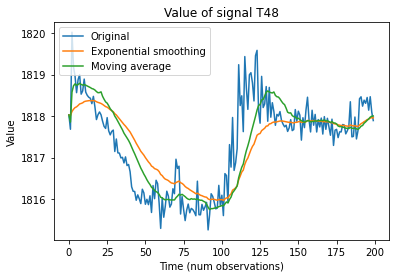

In [69]:
plot_signal_filtering(x_train, 'T48', alpha=0.05, w=20)

Saved object to file: ./experiment_set_15_1\results_no_filtering_final\split_0\scaler.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               4864      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 235,137
Trainable params: 235,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
9253/9253 [==

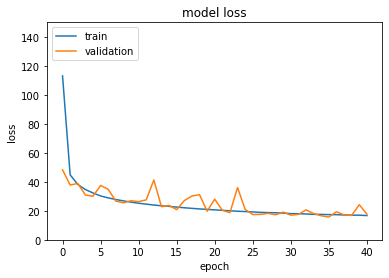

Saved training history to file: ./experiment_set_15_1\results_no_filtering_final\split_0\history_0.pkl
Test set:
MSE: 68.15
RMSE: 8.26
CMAPSS score: 1.84

Saved object to file: ./experiment_set_15_1\results_no_filtering_final\split_1\scaler.pkl
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total p

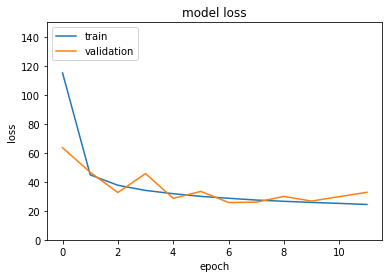

Saved training history to file: ./experiment_set_15_1\results_no_filtering_final\split_1\history_1.pkl
Test set:
MSE: 57.54
RMSE: 7.59
CMAPSS score: 1.74

Saved object to file: ./experiment_set_15_1\results_no_filtering_final\split_2\scaler.pkl
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total p

Epoch 27/60
9245/9253 [============================>.] - ETA: 0s - loss: 19.4920
Epoch 00027: val_loss did not improve from 18.65132
9253/9253 [==============================] - 37s 4ms/step - loss: 19.4977 - val_loss: 22.0738
Epoch 00027: early stopping


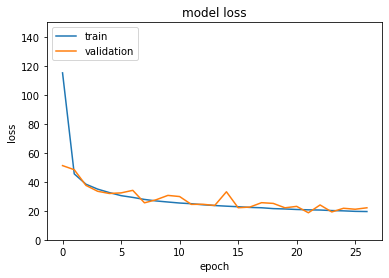

Saved training history to file: ./experiment_set_15_1\results_no_filtering_final\split_2\history_2.pkl
Test set:
MSE: 69.95
RMSE: 8.36
CMAPSS score: 1.85



In [17]:
# Train single MLP for more trials
NUM_TRIALS = 3
EPOCHS = 60
BATCH_SIZE = 512
mlp_config_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)

results_path = os.path.join(output_path, f"results_no_filtering_final")
if not os.path.exists(results_path):
    os.makedirs(results_path)
    
results_file = os.path.join(results_path, "results_no_filtering.csv")
with open(results_file, "w") as file:
    file.write("mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

x_train = x_train[selected_columns]
x_test = x_test[selected_columns]
    
mse_vals, rmse_vals, cmapss_vals = train_evaluate_mlp(
        x_train, y_train, 
        x_test, y_test,
        NUM_TRIALS, 
        mlp_config_params, 
        results_path, 
        EPOCHS, BATCH_SIZE,
        results_file=results_file)

Saved object to file: ./experiment_set_15_1\results_filtered_final\split_0\scaler.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 235,137
Trainable params: 235,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
9253/9253 [========

9250/9253 [============================>.] - ETA: 0s - loss: 10.4582
Epoch 00026: val_loss did not improve from 9.50417
9253/9253 [==============================] - 37s 4ms/step - loss: 10.4577 - val_loss: 17.3185
Epoch 27/60
9245/9253 [============================>.] - ETA: 0s - loss: 10.3433
Epoch 00027: val_loss did not improve from 9.50417
9253/9253 [==============================] - 37s 4ms/step - loss: 10.3421 - val_loss: 10.5437
Epoch 28/60
9241/9253 [============================>.] - ETA: 0s - loss: 10.0909
Epoch 00028: val_loss did not improve from 9.50417
9253/9253 [==============================] - 38s 4ms/step - loss: 10.0920 - val_loss: 12.5353
Epoch 00028: early stopping


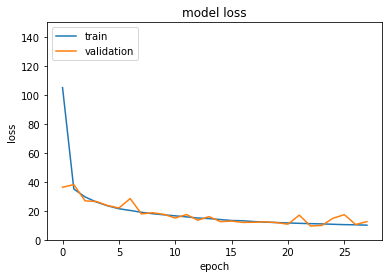

Saved training history to file: ./experiment_set_15_1\results_filtered_final\split_0\history_0.pkl
Test set:
MSE: 70.61
RMSE: 8.40
CMAPSS score: 1.86

Saved object to file: ./experiment_set_15_1\results_filtered_final\split_1\scaler.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               4864      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2

9253/9253 [==============================] - 37s 4ms/step - loss: 10.1867 - val_loss: 9.1693
Epoch 27/60
9241/9253 [============================>.] - ETA: 0s - loss: 10.0917
Epoch 00027: val_loss did not improve from 9.16930
9253/9253 [==============================] - 37s 4ms/step - loss: 10.0912 - val_loss: 13.9748
Epoch 28/60
9241/9253 [============================>.] - ETA: 0s - loss: 9.8122
Epoch 00028: val_loss did not improve from 9.16930
9253/9253 [==============================] - 37s 4ms/step - loss: 9.8136 - val_loss: 12.2692
Epoch 29/60
9242/9253 [============================>.] - ETA: 0s - loss: 9.7407- ETA: 1s - loss:  
Epoch 00029: val_loss improved from 9.16930 to 8.10686, saving model to ./experiment_set_15_1\results_filtered_final\split_1\mlp_model_trained.h5
9253/9253 [==============================] - 37s 4ms/step - loss: 9.7405 - val_loss: 8.1069
Epoch 30/60
9252/9253 [============================>.] - ETA: 0s - loss: 9.6541
Epoch 00030: val_loss improved from 8.10

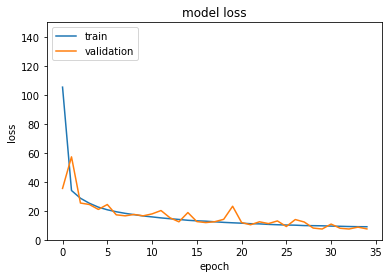

Saved training history to file: ./experiment_set_15_1\results_filtered_final\split_1\history_1.pkl
Test set:
MSE: 71.65
RMSE: 8.46
CMAPSS score: 1.88

Saved object to file: ./experiment_set_15_1\results_filtered_final\split_2\scaler.pkl
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 2

9253/9253 [==============================] - 36s 4ms/step - loss: 10.2074 - val_loss: 8.9250
Epoch 26/60
9250/9253 [============================>.] - ETA: 0s - loss: 10.1914
Epoch 00026: val_loss did not improve from 8.92501
9253/9253 [==============================] - 37s 4ms/step - loss: 10.1919 - val_loss: 14.4768
Epoch 27/60
9241/9253 [============================>.] - ETA: 0s - loss: 9.8621
Epoch 00027: val_loss did not improve from 8.92501
9253/9253 [==============================] - 37s 4ms/step - loss: 9.8615 - val_loss: 9.8209
Epoch 28/60
9245/9253 [============================>.] - ETA: 0s - loss: 9.7937
Epoch 00028: val_loss improved from 8.92501 to 8.18390, saving model to ./experiment_set_15_1\results_filtered_final\split_2\mlp_model_trained.h5
9253/9253 [==============================] - 37s 4ms/step - loss: 9.7921 - val_loss: 8.1839
Epoch 29/60
9245/9253 [============================>.] - ETA: 0s - loss: 9.7255
Epoch 00029: val_loss did not improve from 8.18390
9253/9253

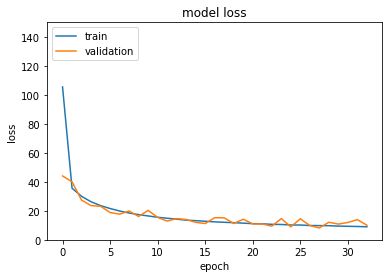

Saved training history to file: ./experiment_set_15_1\results_filtered_final\split_2\history_2.pkl
Test set:
MSE: 70.61
RMSE: 8.40
CMAPSS score: 1.87



In [15]:
# Train single MLP for more trials
NUM_TRIALS = 3
EPOCHS = 60
BATCH_SIZE = 512
mlp_config_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)
alpha = 0.01

results_path = os.path.join(output_path, f"results_filtered_final")
if not os.path.exists(results_path):
    os.makedirs(results_path)
    
results_file = os.path.join(results_path, "results_filtered.csv")
with open(results_file, "w") as file:
    file.write("mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

x_train_filtered = exponential_smoothing(x_train, selected_columns, alpha=alpha)
x_test_filtered = exponential_smoothing(x_test, selected_columns, alpha=alpha)

x_train_filtered = x_train_filtered[selected_columns].astype(np.float32)
x_test_filtered = x_test_filtered[selected_columns].astype(np.float32)

mse_vals, rmse_vals, cmapss_vals = train_evaluate_mlp(
        x_train_filtered, y_train, 
        x_test_filtered, y_test,
        NUM_TRIALS, 
        mlp_config_params, 
        results_path, 
        EPOCHS, BATCH_SIZE,
        results_file=results_file)

Saved object to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_0\scaler.pkl
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
___________________

Epoch 26/60
9237/9253 [============================>.] - ETA: 0s - loss: 33.7765
Epoch 00026: val_loss did not improve from 26.40965
9253/9253 [==============================] - 28s 3ms/step - loss: 33.7803 - val_loss: 35.6042
Epoch 27/60
9246/9253 [============================>.] - ETA: 0s - loss: 33.4889
Epoch 00027: val_loss did not improve from 26.40965
9253/9253 [==============================] - 28s 3ms/step - loss: 33.4877 - val_loss: 34.4666
Epoch 28/60
9235/9253 [============================>.] - ETA: 0s - loss: 33.2737
Epoch 00028: val_loss did not improve from 26.40965
9253/9253 [==============================] - 28s 3ms/step - loss: 33.2769 - val_loss: 27.4879
Epoch 29/60
9239/9253 [============================>.] - ETA: 0s - loss: 32.8705
Epoch 00029: val_loss did not improve from 26.40965
9253/9253 [==============================] - 28s 3ms/step - loss: 32.8716 - val_loss: 33.9480
Epoch 30/60
9253/9253 [==============================] - ETA: 0s - loss: 32.7883
Epoch 00030

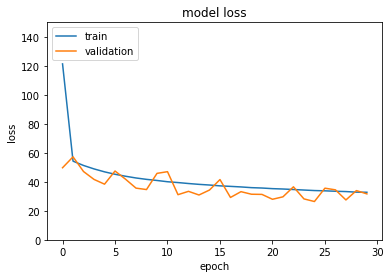

Saved training history to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_0\history_0.pkl
Test set:
MSE: 53.53
RMSE: 7.32
CMAPSS score: 1.69

Saved object to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_1\scaler.pkl
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)            

9247/9253 [============================>.] - ETA: 0s - loss: 34.5566
Epoch 00024: val_loss did not improve from 28.56728
9253/9253 [==============================] - 29s 3ms/step - loss: 34.5565 - val_loss: 30.5072
Epoch 25/60
9238/9253 [============================>.] - ETA: 0s - loss: 34.2807
Epoch 00025: val_loss did not improve from 28.56728
9253/9253 [==============================] - 29s 3ms/step - loss: 34.2917 - val_loss: 35.0793
Epoch 26/60
9240/9253 [============================>.] - ETA: 0s - loss: 33.9418
Epoch 00026: val_loss improved from 28.56728 to 26.96953, saving model to ./experiment_set_15_1\results_no_filtering_new_architecture\split_1\mlp_model_trained.h5
9253/9253 [==============================] - 29s 3ms/step - loss: 33.9401 - val_loss: 26.9695
Epoch 27/60
9241/9253 [============================>.] - ETA: 0s - loss: 33.7536
Epoch 00027: val_loss improved from 26.96953 to 26.82258, saving model to ./experiment_set_15_1\results_no_filtering_new_architecture\split

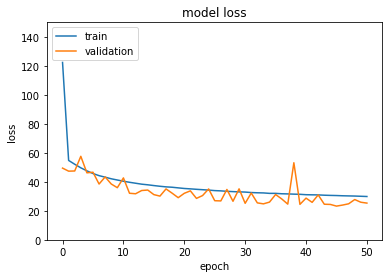

Saved training history to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_1\history_1.pkl
Test set:
MSE: 57.42
RMSE: 7.58
CMAPSS score: 1.73

Saved object to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_2\scaler.pkl
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               2432      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)            

9242/9253 [============================>.] - ETA: 0s - loss: 34.6478
Epoch 00024: val_loss improved from 29.24085 to 28.21967, saving model to ./experiment_set_15_1\results_no_filtering_new_architecture\split_2\mlp_model_trained.h5
9253/9253 [==============================] - 30s 3ms/step - loss: 34.6470 - val_loss: 28.2197
Epoch 25/60
9249/9253 [============================>.] - ETA: 0s - loss: 34.3143
Epoch 00025: val_loss improved from 28.21967 to 27.80852, saving model to ./experiment_set_15_1\results_no_filtering_new_architecture\split_2\mlp_model_trained.h5
9253/9253 [==============================] - 30s 3ms/step - loss: 34.3128 - val_loss: 27.8085
Epoch 26/60
9253/9253 [==============================] - ETA: 0s - loss: 34.1231
Epoch 00026: val_loss did not improve from 27.80852
9253/9253 [==============================] - 29s 3ms/step - loss: 34.1231 - val_loss: 32.7536
Epoch 27/60
9247/9253 [============================>.] - ETA: 0s - loss: 33.8371
Epoch 00027: val_loss improv

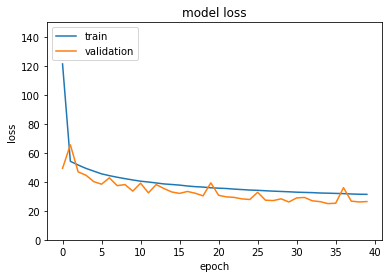

Saved training history to file: ./experiment_set_15_1\results_no_filtering_new_architecture\split_2\history_2.pkl
Test set:
MSE: 56.77
RMSE: 7.53
CMAPSS score: 1.72



In [18]:
NUM_TRIALS = 3
EPOCHS = 60
BATCH_SIZE = 512
mlp_config_params = MLPConfigParams(layer_sizes=[128, 256, 64], activation='tanh', dropout=0.05)

results_path = os.path.join(output_path, f"results_no_filtering_new_architecture")
if not os.path.exists(results_path):
    os.makedirs(results_path)
    
results_file = os.path.join(results_path, "results_no_filtering_new_arch.csv")
with open(results_file, "w") as file:
    file.write("mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

x_train = x_train[selected_columns]
x_test = x_test[selected_columns]
    
mse_vals, rmse_vals, cmapss_vals = train_evaluate_mlp(
        x_train, y_train, 
        x_test, y_test,
        NUM_TRIALS, 
        mlp_config_params, 
        results_path, 
        EPOCHS, BATCH_SIZE,
        results_file=results_file)